In [3]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Generate fake

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
def normalize(x):
    x_min = x.min()
    x_max = x.max()
    
    if (x_max -x_min) == 0:
         x = np.zeros_like(x)
    else:
        x = (x-x_min)/(x_max -x_min)
    return x

In [97]:
def normalize(x):
    x_mean = x.mean()
    x_std = x.std()
    
    if x_std == 0:
        x = np.zeros_like(x)
    else:
        x = (x-x_mean)/(x_std)
    return x

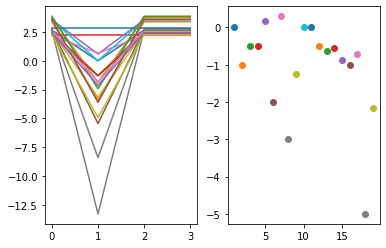

In [212]:
time_steps = 20
n_cells = 4 # Amount of cells in pack
x = np.zeros([time_steps,n_cells])


fig, ax = plt.subplots(1,2)

failed_cell = 1 # Which cell is the failing cell
is_fail = True# Does the pack include a failed cell
volt_stochastic = 0.9
for i in range(1,time_steps):
    sigma = 0.0 # How much is the fluctuation
    median = random.uniform(2, 4)
    volt = np.random.normal(loc=median, scale=sigma, size=n_cells)
    if is_fail:
        r = random.random()
        if r < volt_stochastic:
            stochstic_amplifier = random.randint(1,10)
            
            y = (1-i/stochstic_amplifier)
            #print(y)
            volt[failed_cell]*=y
    ax[1].scatter(i,y)
    x[i,:] = volt
            
    ax[0].plot(volt, label=i)
#plt.ylim(0,16)
#plt.legend()

In [213]:
def create_sequence(time_steps=2, n_cells=4, failed_cell=1, is_fail=True, sigma=0.0, volt_stochastic = 0.9, normalize_x=False):
    x = np.zeros([time_steps,n_cells])
    for i in range(0,time_steps):
        median = random.uniform(2, 4)
        volt = np.random.normal(loc=median, scale=sigma, size=n_cells)
        if is_fail:
            r = random.random()
            if r < volt_stochastic:
                stochstic_amplifier = random.randint(1,10) # 100, 1000

                y = (1-(i+1)/stochstic_amplifier)
                #print(y)
                volt[failed_cell]*=y
        x[i,:] = volt
    if normalize_x:
        x_norm = np.zeros_like(x)
        for i in range(len(x)):
            x_norm[i,:] = normalize(x[i,:])
        #x = normalize(x)
        x = x_norm
    if is_fail:
        label = 1
    else:
        label = 0
    return x, label
    

In [214]:
volt[failed_cell]*=y
volt

array([ 2.27412113, 10.67573533,  2.27412113,  2.27412113])

In [215]:
time_steps=2 
n_cells=4
failed_cell=1 
is_fail=True 
sigma=0.0 
volt_stochastic = 0.9 
normalize_x=False


array([[ 0.05068827,  0.05068827,  0.05068827,  0.05068827],
       [ 0.76475872,  0.76475872, -2.49702925,  0.76475872]])

In [276]:
time_steps=20 
n_cells=50
failed_cell=1 
sigma=2
volt_stochastic = 1
normalize_x=False

def create_data(n_healthy=2, n_fails=2,time_steps=time_steps):
    data = []
    
    data_info ={"index_1":[],
           "index_0": []} 
    
    for i in range(n_healthy+n_fails):
        if i >= n_healthy:
            fail=True
        else:
            fail=False
        x,y = create_sequence(time_steps=time_steps, n_cells=n_cells, failed_cell=failed_cell, is_fail=fail, sigma=sigma, volt_stochastic = volt_stochastic, normalize_x=normalize_x)
        data.append((torch.FloatTensor(x),y))
        
        #Finn data_info
        if y == 1:
            data_info["index_1"].append(i)
            
        if y == 0:
            data_info["index_0"].append(i)
            
    return (data, data_info)
    

data, data_info = create_data(n_healthy=1000, n_fails=1000)

## plot n random samples from failed

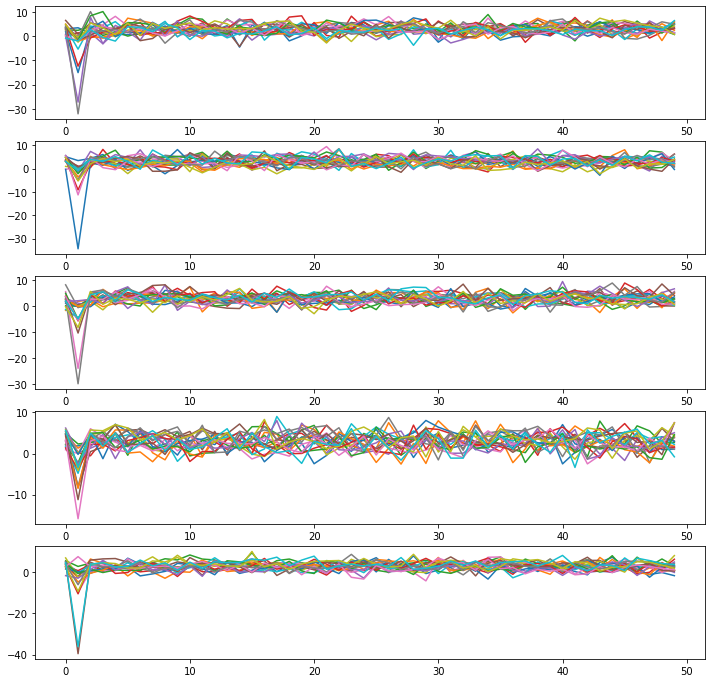

In [277]:
select_samples = 5
sample_from = random.randint(min(data_info["index_1"]), max(data_info["index_1"])-select_samples)
fig, ax = plt.subplots(select_samples,1,figsize=(12,12))
for i,j in enumerate(range(sample_from, sample_from+select_samples)):

    ax[i].plot(data[j][0].T)
plt.show()

## Create dataset

In [278]:
data, data_info = create_data(n_healthy=1000, n_fails=10)

In [279]:
train_size = int(len(data)*0.8)
test_size = len(data) - train_size
train_set, test_set = torch.utils.data.random_split(data,[train_size, test_size])
batch_size = 10
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True,drop_last=True)

In [280]:
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

In [281]:
class ANNMultilayerperceptron(nn.Module):

    def __init__(self, input_size=(time_steps*n_cells),output_size=2, layers=[220,84]):  # 120, 84
        super().__init__()

        self.fc1 = nn.Linear(input_size, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc2b = nn.Linear(layers[1], 100)
        self.fc2c = nn.Linear(100, layers[1])
        self.fc2d = nn.Linear(layers[1], layers[1])
        self.fc3 = nn.Linear(layers[1], output_size)

    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc2b(X))
        X = F.relu(self.fc2c(X))
        X = F.relu(self.fc2d(X))
        X = self.fc3(X)

        return F.log_softmax(X,dim=1) # PGA multiclass classification
        #return X

In [282]:
model = ANNMultilayerperceptron()
model

ANNMultilayerperceptron(
  (fc1): Linear(in_features=1000, out_features=220, bias=True)
  (fc2): Linear(in_features=220, out_features=84, bias=True)
  (fc2b): Linear(in_features=84, out_features=100, bias=True)
  (fc2c): Linear(in_features=100, out_features=84, bias=True)
  (fc2d): Linear(in_features=84, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [283]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [284]:
#from ignite.metrics import Precision, Recall
#from ignite.metrics import Precision ### LÄGG TILL IGNITE
#train_precision = Precision()
#train_recall = Recall()

#test_precision = Precision()
#test_recall = Recall()
# https://pytorch.org/ignite/metrics.html


epochs =20 # Ju störra dataset ju färre epochs behövs

train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop epochs 

for i in range(epochs):
    trn_correct = 0
    tst_correct = 0 

    # Train

    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Skip iteration if batch size not equal to stated dim
        
            
        #print(X_train.shape, y_train.shape) 
        
        b += 1
        
        y_pred = model(X_train.view(batch_size, -1))  # Flatten input
        lossTrain = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data,1)[1]

        #calculate precision and recall
        #train_precision.update((y_pred, y_train))
        #train_recall.update((y_pred, y_train))
      

        batch_corr = (predicted == y_train).sum()
        trn_correct += batch_corr

        optimizer.zero_grad()
        lossTrain.backward()
        optimizer.step()

        if b%2 == 0: 
            print(f"Epoch {i} Batch: {b} Train Loss: {lossTrain.item()}")

    train_losses.append(lossTrain.data.item())
    train_correct.append(trn_correct)

    # Test
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            y_val = model(X_train.view(batch_size, -1))

            predicted = torch.max(y_val.data,1)[1]

            
        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(trn_correct)

        #if b%2 == 0:
            #print(f"Epoch {i} Batch: {b} Train Loss: {lossTrain.item()} Validation Loss: {loss.item()}")


Epoch 0 Batch: 2 Train Loss: 0.6148830652236938
Epoch 0 Batch: 4 Train Loss: 0.5697225332260132
Epoch 0 Batch: 6 Train Loss: 0.5250777006149292
Epoch 0 Batch: 8 Train Loss: 0.4763108789920807
Epoch 0 Batch: 10 Train Loss: 0.4274473190307617
Epoch 0 Batch: 12 Train Loss: 0.375283807516098
Epoch 0 Batch: 14 Train Loss: 0.30281510949134827
Epoch 0 Batch: 16 Train Loss: 0.2613489627838135
Epoch 0 Batch: 18 Train Loss: 0.20592100918293
Epoch 0 Batch: 20 Train Loss: 0.14642389118671417
Epoch 0 Batch: 22 Train Loss: 0.11991626024246216
Epoch 0 Batch: 24 Train Loss: 0.08178849518299103
Epoch 0 Batch: 26 Train Loss: 0.05247768014669418
Epoch 0 Batch: 28 Train Loss: 0.038035329431295395
Epoch 0 Batch: 30 Train Loss: 0.027034778147935867
Epoch 0 Batch: 32 Train Loss: 0.017643587663769722
Epoch 0 Batch: 34 Train Loss: 0.016813864931464195
Epoch 0 Batch: 36 Train Loss: 0.010466310195624828
Epoch 0 Batch: 38 Train Loss: 0.007659580558538437
Epoch 0 Batch: 40 Train Loss: 0.005805359687656164
Epoch 0 

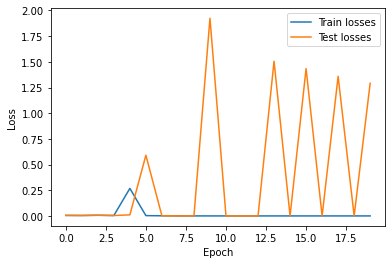

In [285]:
plt.plot(train_losses, label="Train losses")
plt.plot(test_losses, label= "Test losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Create confusion matrix

F1 score 0.5714285714285715


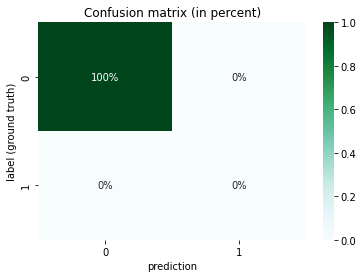

In [288]:
from sklearn.metrics import f1_score
test_loader_all = DataLoader(dataset=test_set, batch_size=len(test_set), shuffle=True,drop_last=True)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_loader_all:
        y_val = model(X_test.view(len(test_set),-1))
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
# Create confusion matrix        
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
f1 = f1_score(y_test.view(-1), predicted.view(-1))

arr2 = np.zeros([2,2])
arr2[0] = (arr[0]/arr[0].sum()).astype(int)
arr2[1] = (arr[1]/arr[1].sum()).astype(int)

df_cm = pd.DataFrame(arr2)
#sns.heatmap(df_cm, annot=True, cmap="BuGn")
sns.heatmap(df_cm, annot=True, cmap="BuGn",fmt='.0%')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.title("Confusion matrix (in percent)")
print(f"F1 score {f1}")
plt.show()

In [ ]:

import numpy as np
for _ in range(100):
    # Select random sample
    i = np.random.randint(1,len(test_set))
    x = test_set[i][0]
    y = test_set[i][1]


    # Evaluate on sample
    model.eval()
    with torch.no_grad():
        new_pred =model(x.view(1,-1))
        pred_int = int(torch.max(new_pred.data,1)[1])
    print(f"Random sample {i} selected with state {y}. Model predict state is {pred_int}")
###################################################################################################################

import numpy as np
for _ in range(100):
    # Select random sample
    i = np.random.randint(1,len(train_set))
    x = train_set[i][0]
    y = train_set[i][1]


    # Evaluate on sample
    model.eval()
    with torch.no_grad():
        new_pred =model(x.view(1,-1))
        pred_int = int(torch.max(new_pred.data,1)[1])
    print(f"Random sample {i} selected with state {y}. Model predict state is {pred_int}")